#Libraries and Data

In [20]:
#import libraries
import numpy as np
import pandas as pd
import itertools
from prophet import Prophet
import yfinance
import pickle
import talib
from talib import abstract

In [29]:
#load the datast
#[OLECTRA,"LT","CONCOR","ELGIEQUIP","IOC","BEL","TATAELXSI","^NSEI"]
stock_name = "ELGIEQUIP"
data = yfinance.download (tickers = "{}.NS".format(stock_name),start="2000-03-06",
                               interval = "1d", group_by = 'ticker', auto_adjust = True)


data.tail()

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Volume
Date,,,,,
2023-07-12,559.00,623.000000,556.650024,583.200012,8440159
2023-07-13,588.75,591.700012,561.049988,566.900024,735213
2023-07-14,570.00,581.349976,564.000000,572.950012,467965
2023-07-17,573.00,578.000000,565.049988,576.200012,301825
2023-07-19,564.00,573.599976,553.000000,566.099976,380886


#Data preparation

In [30]:
#transform the date variable
data["Date"] = pd.to_datetime(data.index, format = "%m/%d/%Y")
data.Date

Date
2002-07-01   2002-07-01
2002-07-02   2002-07-02
2002-07-03   2002-07-03
2002-07-04   2002-07-04
2002-07-05   2002-07-05
                ...    
2023-07-12   2023-07-12
2023-07-13   2023-07-13
2023-07-14   2023-07-14
2023-07-17   2023-07-17
2023-07-19   2023-07-19
Name: Date, Length: 5229, dtype: datetime64[ns]

In [31]:
new_column_names = {'High': 'high', 'Low': 'low',"Close":"close","Open": "open"}
data.rename(columns=new_column_names, inplace=True)

In [24]:
data

,open,high,low,close,Volume,Date
Date,,,,,,
2002-07-01,3.750483,3.821921,3.661186,3.768343,121880,2002-07-01
2002-07-02,3.804062,3.929078,3.750484,3.902289,231080,2002-07-02
2002-07-03,3.946939,3.946939,3.795134,3.857642,218240,2002-07-03
2002-07-04,3.920149,4.080884,3.884430,3.964798,354252,2002-07-04
2002-07-05,4.063024,4.063024,3.839781,3.884430,272724,2002-07-05
...,...,...,...,...,...,...
2023-07-12,559.000000,623.000000,556.650024,583.200012,8440159,2023-07-12
2023-07-13,588.750000,591.700012,561.049988,566.900024,735213,2023-07-13
2023-07-14,570.000000,581.349976,564.000000,572.950012,467965,2023-07-14


In [32]:
all_indicators = talib.get_function_groups()["Pattern Recognition"]


In [33]:
all_indicators

['CDL2CROWS',
 'CDL3BLACKCROWS',
 'CDL3INSIDE',
 'CDL3LINESTRIKE',
 'CDL3OUTSIDE',
 'CDL3STARSINSOUTH',
 'CDL3WHITESOLDIERS',
 'CDLABANDONEDBABY',
 'CDLADVANCEBLOCK',
 'CDLBELTHOLD',
 'CDLBREAKAWAY',
 'CDLCLOSINGMARUBOZU',
 'CDLCONCEALBABYSWALL',
 'CDLCOUNTERATTACK',
 'CDLDARKCLOUDCOVER',
 'CDLDOJI',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'CDLENGULFING',
 'CDLEVENINGDOJISTAR',
 'CDLEVENINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLGRAVESTONEDOJI',
 'CDLHAMMER',
 'CDLHANGINGMAN',
 'CDLHARAMI',
 'CDLHARAMICROSS',
 'CDLHIGHWAVE',
 'CDLHIKKAKE',
 'CDLHIKKAKEMOD',
 'CDLHOMINGPIGEON',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLINVERTEDHAMMER',
 'CDLKICKING',
 'CDLKICKINGBYLENGTH',
 'CDLLADDERBOTTOM',
 'CDLLONGLEGGEDDOJI',
 'CDLLONGLINE',
 'CDLMARUBOZU',
 'CDLMATCHINGLOW',
 'CDLMATHOLD',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLONNECK',
 'CDLPIERCING',
 'CDLRICKSHAWMAN',
 'CDLRISEFALL3METHODS',
 'CDLSEPARATINGLINES',
 'CDLSHOOTINGSTAR',
 'CDLSHORTLINE',
 'CDLSPINNINGTOP',
 'CDLSTALLEDPATTERN',
 

In [73]:
result = []
for i in range(0,len(data)):
    if i > 1:
        tempData = {}
        last_day = data.iloc[i-1]
        #print((last_day['High'] + last_day['Low'] + last_day['Close'])/3)
        tempData['Pivot'] = (last_day['high'] + last_day['low'] + last_day['close'])/3
        tempData['R1'] = 2 * tempData['Pivot'] - last_day['low']
        tempData['S1'] = 2 * tempData['Pivot'] - last_day['high']
        tempData['R2'] = tempData['Pivot'] + (last_day['high'] - last_day['low'])
        tempData['S2'] = tempData['Pivot'] - (last_day['high'] - last_day['low'])
        tempData['R3'] = tempData['Pivot'] + 2*(last_day['high'] - last_day['low'])
        tempData['S3'] = tempData['Pivot'] - 2*(last_day['high'] - last_day['low'])
        tempData['low'] = last_day['low']
        tempData['high'] = last_day['high']
        tempData['close'] = last_day['close']
        tempData['open'] = last_day['open']
        tempData['Date'] = last_day['Date']
        
        result.append(tempData)
        
df = pd.DataFrame(result)

In [75]:
for indicator in all_indicators:
    if indicator == "CDLHAMMER" or indicator == "CDLSHOOTINGSTAR":
        df[str(indicator)] = getattr(abstract, indicator)(df)

In [86]:
hammer = []
shooting= []
for i in range(0,len(df)):
        if df.iloc[i].CDLSHOOTINGSTAR != 0:
            shooting.append(1)
        else:
            shooting.append(0)
        if df.iloc[i].CDLHAMMER != 0:
            hammer.append(1)
        else:
            hammer.append(0)


In [87]:
df["hammer"] = hammer
df["shooting"] = shooting


In [89]:
df = df.drop(columns=["CDLSHOOTINGSTAR","CDLHAMMER"],axis=1)

,Pivot,R1,S1,R2,S2,R3,S3,low,high,close,open,Date,hammer,shooting
0,3.860618,3.970751,3.792157,4.039213,3.682023,4.217807,3.503429,3.750485,3.929079,3.902290,3.804063,2002-07-02,0,0
1,3.866570,3.938008,3.786203,4.018376,3.714765,4.170181,3.562960,3.795133,3.946938,3.857641,3.946938,2002-07-03,0,0
2,3.976705,4.068979,3.872525,4.173159,3.780251,4.369614,3.583797,3.884431,4.080886,3.964799,3.920151,2002-07-04,0,0
3,3.929079,4.018376,3.795133,4.152322,3.705836,4.375565,3.482593,3.839782,4.063025,3.884430,4.063025,2002-07-05,0,0
4,4.324962,4.765495,3.988609,5.101848,3.548077,5.878734,2.771191,3.884430,4.661315,4.429142,3.929078,2002-07-08,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5222,547.516663,552.183350,540.833313,558.866699,536.166626,570.216736,524.816589,542.849976,554.200012,545.500000,550.000000,2023-07-11,0,0
5223,587.616679,618.583333,552.233358,653.966654,521.266703,720.316630,454.916728,556.650024,623.000000,583.200012,559.000000,2023-07-12,0,0
5224,573.216675,585.383362,554.733337,603.866699,542.566650,634.516724,511.916626,561.049988,591.700012,566.900024,588.750000,2023-07-13,0,0
5225,572.766663,581.533325,564.183350,590.116638,555.416687,607.466614,538.066711,564.000000,581.349976,572.950012,570.000000,2023-07-14,0,0


In [4]:
#renaming variables
data = data.rename(columns = {'Close': 'y',
                     'Date': 'ds'})
data.tail(10)

,Open,High,Low,y,Volume,ds
Date,,,,,,
2023-06-30,531.450012,545.000000,531.049988,541.599976,511759,2023-06-30
2023-07-03,545.900024,546.099976,538.049988,539.299988,174814,2023-07-03
2023-07-04,541.900024,544.700012,538.049988,539.000000,122254,2023-07-04
2023-07-05,548.000000,548.000000,539.049988,540.599976,242769,2023-07-05
2023-07-06,540.599976,543.950012,538.400024,539.549988,128308,2023-07-06
2023-07-07,541.000000,543.750000,535.000000,538.700012,166062,2023-07-07
2023-07-10,539.849976,549.950012,535.400024,546.349976,329748,2023-07-10
2023-07-11,550.000000,554.200012,542.849976,545.500000,522239,2023-07-11
2023-07-12,559.000000,623.000000,556.650024,583.200012,8440159,2023-07-12


#Holidays

In [6]:
#Thanksgiving
#thanksgiving_dates = df[df.Thanksgiving == 1].ds
#thanksgiving = pd.DataFrame({'holiday': 'thanksgiving',
 #                      'ds': pd.to_datetime(thanksgiving_dates),
  #                     'lower_window': -5,
   #                    'upper_window': 2})
#thanksgiving.head(2)

In [7]:
#combining holidays
#holidays = pd.concat([easter, thanksgiving])
#holidays

In [5]:
#create training and test set
test_days = 1000
training_set = data.iloc[:-test_days,:]
test_set = data.iloc[-test_days:,:]

In [6]:
print("Len Traing :",len(training_set),"Len of Test :",len(test_set))

Len Traing : 4226 Len of Test : 1000


#Prophet

In [7]:
m = Prophet(
            #holidays = holidays,
           # seasonality_mode = 'multiplicative',
            #seasonality_prior_scale = 20,
            #changepoint_prior_scale = 0.1,
           # holidays_prior_scale = 10
           )
#m.add_regressor('Christmas')
m.fit(training_set)


13:49:33 - cmdstanpy - INFO - Chain [1] start processing
13:49:36 - cmdstanpy - INFO - Chain [1] done processing


In [85]:
#create future df
#future = m.make_future_dataframe(periods = 1000,
                            #     freq = "B")

print("Lenght of future date :",len(future))

Lenght of future date : 5224


In [8]:
future = pd.DataFrame({"ds":data.index})
future

,ds
0,2002-07-01
1,2002-07-02
2,2002-07-03
3,2002-07-04
4,2002-07-05
...,...
5221,2023-07-07
5222,2023-07-10
5223,2023-07-11
5224,2023-07-12


In [9]:
future = pd.concat([future], axis = 1)


In [10]:
future

,ds
0,2002-07-01
1,2002-07-02
2,2002-07-03
3,2002-07-04
4,2002-07-05
...,...
5221,2023-07-07
5222,2023-07-10
5223,2023-07-11
5224,2023-07-12


In [11]:
#forecast
forecast = m.predict(data)
forecast.tail()


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
5221,2023-07-07,227.318432,192.254971,262.567859,193.438121,262.205216,0.056139,0.056139,0.056139,-0.237092,-0.237092,-0.237092,0.293231,0.293231,0.293231,0.0,0.0,0.0,227.374571
5222,2023-07-10,227.489353,192.796703,263.149186,193.555611,262.428209,0.246874,0.246874,0.246874,-0.337339,-0.337339,-0.337339,0.584214,0.584214,0.584214,0.0,0.0,0.0,227.736227
5223,2023-07-11,227.546327,193.491714,264.990243,193.559321,262.537254,0.314299,0.314299,0.314299,-0.354998,-0.354998,-0.354998,0.669297,0.669297,0.669297,0.0,0.0,0.0,227.860626
5224,2023-07-12,227.603301,191.879093,264.001776,193.565269,262.646299,0.502992,0.502992,0.502992,-0.244708,-0.244708,-0.244708,0.747700,0.747700,0.747700,0.0,0.0,0.0,228.106293
5225,2023-07-13,227.660275,193.235960,264.383020,193.571217,262.755345,0.677019,0.677019,0.677019,-0.142108,-0.142108,-0.142108,0.819127,0.819127,0.819127,0.0,0.0,0.0,228.337294


In [ ]:
#m.plot_components(forecast);

In [45]:
prophet_res = { "actual":forecast.yhat,"real":data.y ,"actual_date" :forecast.ds,"real_date":data.ds}
prophet_res_df = pd.DataFrame(prophet_res)

In [46]:
prophet_res_df.tail(200)

,actual,real,actual_date,real_date
5026,210.676560,463.799988,2022-09-22,2022-09-22
5027,210.533035,449.950012,2022-09-23,2022-09-23
5028,210.297441,421.450012,2022-09-26,2022-09-26
5029,210.241531,410.149994,2022-09-27,2022-09-27
5030,210.318583,405.799988,2022-09-28,2022-09-28
...,...,...,...,...
5221,227.374571,538.700012,2023-07-07,2023-07-07
5222,227.736227,546.349976,2023-07-10,2023-07-10
5223,227.860626,545.500000,2023-07-11,2023-07-11
5224,228.106293,583.200012,2023-07-12,2023-07-12


In [48]:
#predictions
predictions_prophet = forecast.yhat[-test_days:].rename("prophet")
predictions_prophet[:5]

4226    143.169059
4227    143.453119
4228    143.728463
4229    143.804196
4230    144.195064
Name: prophet, dtype: float64

In [52]:
predictions_prophet.tail()

5221    227.374571
5222    227.736227
5223    227.860626
5224    228.106293
5225    228.337294
Name: prophet, dtype: float64

In [49]:
#MAE and RMSE
from sklearn.metrics import mean_squared_error, mean_absolute_error
print(round(mean_absolute_error(test_set['y'], predictions_prophet),0))
print(round(np.sqrt(mean_squared_error(test_set['y'], predictions_prophet)), 0))

106.0
144.0


In [50]:
#MAPE function
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set['y'], predictions_prophet)

43.38742827503385

In [ ]:
#CV
from prophet.diagnostics import cross_validation
df_cv = cross_validation(m,
                         horizon = '31 days',
                         initial = '540 days',
                         parallel = "processes")
df_cv.head()

Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.
14:09:44 - cmdstanpy - INFO - Chain [1] start processing
14:09:44 - cmdstanpy - INFO - Chain [1] start processing
14:09:44 - cmdstanpy - INFO - Chain [1] start processing
14:09:44 - cmdstanpy - INFO - Chain [1] start processing
14:09:44 - cmdstanpy - INFO - Chain [1] done processing
14:09:44 - cmdstanpy - INFO - Chain [1] done processing
14:09:45 - cmdstanpy - INFO - Chain [1] done processing
14:09:45 - cmdstanpy - INFO - Chain [1] done processing
14:09:45 - cmdstanpy - INFO - Chain [1] start processing
14:09:45 - cmdstanpy - INFO - Chain [1] start processing
14:09:45 - cmdstanpy - INFO - Chain [1] start processing
14:09:45 - cmdstanpy - INFO - Chain [1] start processing
14:09:45 - cmdstanpy - INFO - Chain [1] done processing
14:09:45 - cmdstanpy - INFO - Ch

14:10:04 - cmdstanpy - INFO - Chain [1] done processing
14:10:04 - cmdstanpy - INFO - Chain [1] start processing
14:10:04 - cmdstanpy - INFO - Chain [1] start processing
14:10:04 - cmdstanpy - INFO - Chain [1] done processing
14:10:05 - cmdstanpy - INFO - Chain [1] start processing
14:10:05 - cmdstanpy - INFO - Chain [1] done processing
14:10:05 - cmdstanpy - INFO - Chain [1] done processing
14:10:05 - cmdstanpy - INFO - Chain [1] done processing
14:10:06 - cmdstanpy - INFO - Chain [1] start processing
14:10:06 - cmdstanpy - INFO - Chain [1] start processing
14:10:06 - cmdstanpy - INFO - Chain [1] start processing
14:10:06 - cmdstanpy - INFO - Chain [1] done processing
14:10:06 - cmdstanpy - INFO - Chain [1] start processing
14:10:07 - cmdstanpy - INFO - Chain [1] done processing
14:10:07 - cmdstanpy - INFO - Chain [1] done processing
14:10:07 - cmdstanpy - INFO - Chain [1] start processing
14:10:07 - cmdstanpy - INFO - Chain [1] start processing
14:10:08 - cmdstanpy - INFO - Chain [1]

14:10:48 - cmdstanpy - INFO - Chain [1] done processing
14:10:49 - cmdstanpy - INFO - Chain [1] start processing
14:10:49 - cmdstanpy - INFO - Chain [1] done processing
14:10:49 - cmdstanpy - INFO - Chain [1] done processing
14:10:50 - cmdstanpy - INFO - Chain [1] done processing
14:10:50 - cmdstanpy - INFO - Chain [1] start processing
14:10:50 - cmdstanpy - INFO - Chain [1] start processing
14:10:50 - cmdstanpy - INFO - Chain [1] start processing
14:10:51 - cmdstanpy - INFO - Chain [1] done processing
14:10:51 - cmdstanpy - INFO - Chain [1] start processing
14:10:53 - cmdstanpy - INFO - Chain [1] done processing
14:10:53 - cmdstanpy - INFO - Chain [1] done processing
14:10:53 - cmdstanpy - INFO - Chain [1] done processing
14:10:53 - cmdstanpy - INFO - Chain [1] start processing
14:10:54 - cmdstanpy - INFO - Chain [1] done processing
14:10:54 - cmdstanpy - INFO - Chain [1] start processing
14:10:54 - cmdstanpy - INFO - Chain [1] start processing
14:10:54 - cmdstanpy - INFO - Chain [1] 

14:12:33 - cmdstanpy - INFO - Chain [1] start processing
14:12:34 - cmdstanpy - INFO - Chain [1] start processing
14:12:36 - cmdstanpy - INFO - Chain [1] done processing
14:12:37 - cmdstanpy - INFO - Chain [1] start processing
14:12:38 - cmdstanpy - INFO - Chain [1] done processing
14:12:39 - cmdstanpy - INFO - Chain [1] start processing
14:12:39 - cmdstanpy - INFO - Chain [1] done processing
14:12:39 - cmdstanpy - INFO - Chain [1] done processing
14:12:40 - cmdstanpy - INFO - Chain [1] start processing
14:12:40 - cmdstanpy - INFO - Chain [1] start processing
14:12:43 - cmdstanpy - INFO - Chain [1] done processing
14:12:44 - cmdstanpy - INFO - Chain [1] start processing
14:12:45 - cmdstanpy - INFO - Chain [1] done processing
14:12:46 - cmdstanpy - INFO - Chain [1] start processing
14:12:46 - cmdstanpy - INFO - Chain [1] done processing
14:12:46 - cmdstanpy - INFO - Chain [1] done processing
14:12:47 - cmdstanpy - INFO - Chain [1] start processing
14:12:47 - cmdstanpy - INFO - Chain [1]

14:15:22 - cmdstanpy - INFO - Chain [1] start processing
14:15:23 - cmdstanpy - INFO - Chain [1] start processing
14:15:25 - cmdstanpy - INFO - Chain [1] done processing
14:15:26 - cmdstanpy - INFO - Chain [1] done processing
14:15:26 - cmdstanpy - INFO - Chain [1] start processing
14:15:28 - cmdstanpy - INFO - Chain [1] start processing
14:15:28 - cmdstanpy - INFO - Chain [1] done processing
14:15:29 - cmdstanpy - INFO - Chain [1] done processing


In [12]:
data = data.reset_index(level=None, drop=False, inplace=False, col_level=0, col_fill='')
data

,Date,Open,High,Low,y,Volume,ds
0,2002-07-01,3.750484,3.821922,3.661187,3.768344,121880,2002-07-01
1,2002-07-02,3.804062,3.929078,3.750484,3.902289,231080,2002-07-02
2,2002-07-03,3.946937,3.946937,3.795132,3.857640,218240,2002-07-03
3,2002-07-04,3.920150,4.080885,3.884431,3.964798,354252,2002-07-04
4,2002-07-05,4.063026,4.063026,3.839782,3.884431,272724,2002-07-05
...,...,...,...,...,...,...,...
5221,2023-07-07,541.000000,543.750000,535.000000,538.700012,166062,2023-07-07
5222,2023-07-10,539.849976,549.950012,535.400024,546.349976,329748,2023-07-10
5223,2023-07-11,550.000000,554.200012,542.849976,545.500000,522239,2023-07-11
5224,2023-07-12,559.000000,623.000000,556.650024,583.200012,8440159,2023-07-12


In [ ]:
#evaluate prophet mode

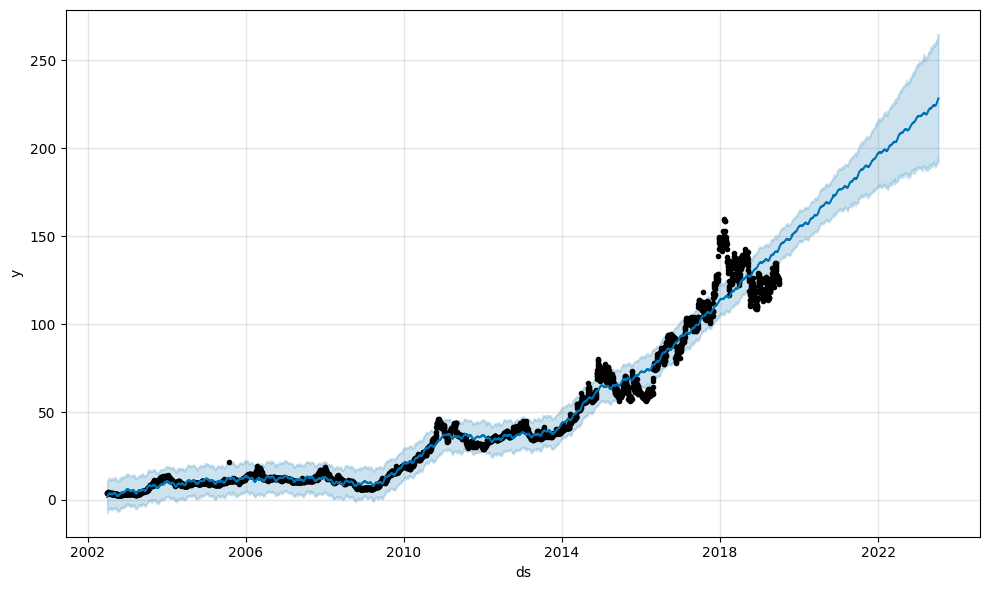

In [19]:
m.plot(forecast);

In [13]:
#get some variables
prophet_variables = forecast.loc[:, ["trend", "weekly",  "multiplicative_terms"]]
df_xgb = pd.concat([data, prophet_variables], axis = 1)


#XGBoost preparation

In [14]:
#create training and test set
test_days = 1000
training_set = df_xgb.iloc[:-test_days,:]
test_set = df_xgb.iloc[-test_days:,:]

In [15]:
print("Train len : ",len(training_set),"Test length :",len(test_set))

Train len :  4226 Test length : 1000


In [16]:
#isolate X and y
y_train = training_set.y
y_test = test_set.y 
X_train = training_set.iloc[:, 2:]
X_test = test_set.iloc[:, 2:]



In [17]:
X_train = X_train.drop(columns=["ds"])
X_test = X_test.drop(columns=["ds"])
#x_train_full = x_train_full.drop(columns=["ds"])

In [18]:
#Matrices
import xgboost as xgb
Train = xgb.DMatrix(X_train, label = y_train)
Test = xgb.DMatrix(X_test, label = y_test)

In [139]:
#Matrices FULL DATA
Train_full = xgb.DMatrix(x_train_full, label = y_train_full)

In [140]:
#set the parameters
parameters = {'learning_rate': 0.3,
              'max_depth': 6,
              'colsample_bytree': 1,
              'subsample': 1,
              'min_child_weight' : 1,
              'gamma': 0,
              'random_state': 1502,
              'eval_metric': "rmse",
              'objective': "reg:squarederror"}

#XGBoost

In [141]:
model = xgb.train(params = parameters,
                  dtrain = Train,
                  num_boost_round = 40,
                  evals = [(Test, "y")])

[0]	y-rmse:258.82770
[1]	y-rmse:235.41108
[2]	y-rmse:218.85376
[3]	y-rmse:206.79595
[4]	y-rmse:198.10864
[5]	y-rmse:191.97354
[6]	y-rmse:187.85032
[7]	y-rmse:184.35636
[8]	y-rmse:181.38163
[9]	y-rmse:179.12385
[10]	y-rmse:177.24517
[11]	y-rmse:175.82413
[12]	y-rmse:174.74882
[13]	y-rmse:173.93318
[14]	y-rmse:173.31469
[15]	y-rmse:172.84544
[16]	y-rmse:172.62653
[17]	y-rmse:172.34996
[18]	y-rmse:172.13999
[19]	y-rmse:172.03359
[20]	y-rmse:172.01351
[21]	y-rmse:171.92789
[22]	y-rmse:171.92883
[23]	y-rmse:171.88646
[24]	y-rmse:171.78435
[25]	y-rmse:171.69759
[26]	y-rmse:171.62388
[27]	y-rmse:171.60974
[28]	y-rmse:171.55647
[29]	y-rmse:171.55882
[30]	y-rmse:171.51533
[31]	y-rmse:171.51589
[32]	y-rmse:171.51130
[33]	y-rmse:171.47609
[34]	y-rmse:171.47689
[35]	y-rmse:171.49010
[36]	y-rmse:171.45905
[37]	y-rmse:171.43266
[38]	y-rmse:171.43602
[39]	y-rmse:171.43613


In [142]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

#VIZ and assessment

In [143]:
#Visualization
training_set.index = training_set.ds
test_set.index = test_set.ds

In [144]:
#forecasting
predictions = pd.Series(model.predict(Test), name = "XGBoost")
predictions.index  =test_set.ds

<Axes: xlabel='ds'>

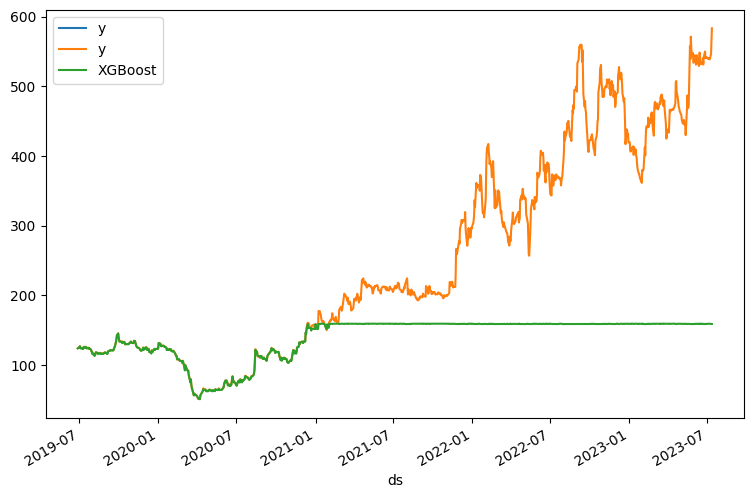

In [145]:
training_set.y['2020-01-01':].plot(figsize = (9,6), legend = True)
test_set.y.plot(legend = True)
predictions.plot(legend = True)

In [146]:
dir(model)
print("feature name :",model)

['__class__',
 '__copy__',
 '__deepcopy__',
 '__del__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_configure_constraints',
 '_get_feature_info',
 '_set_feature_info',
 '_transform_interaction_constraints',
 '_transform_monotone_constrains',
 '_validate_dmatrix_features',
 '_validate_features',
 'attr',
 'attributes',
 'best_iteration',
 'best_ntree_limit',
 'boost',
 'copy',
 'dump_model',
 'eval',
 'eval_set',
 'feature_names',
 'feature_types',
 'get_dump',
 'get_fscore',
 'get_score',
 'get_split_value_histogram',
 'handle',
 'inplace_predict',
 'load_config',
 'load_model',
 'num_boosted_rounds',
 'num_features',
 'predict

In [36]:
#MAPE
def MAPE(y_true, y_pred):
  y_true, y_pred = np.array(y_true), np.array(y_pred)
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100
MAPE(test_set.y, predictions)

0.7537478872023836

#Future



In [36]:
# Create a dictionary with data
data = {
    'High': [4.123123],
    'Low': [4.123123],
    'y': [210.935516],
    'Volume': [4.123123],
    'trend': [8.12313],
    'weekly': [4.123123],
    'multiplicative_terms': [4.444],
                

                
                }

# Create a new DataFrame object
df = pd.DataFrame(data)


In [37]:
Future = xgb.DMatrix(df, label = df.y)
f_predictions = pd.Series(model.predict(Future), name = "XGBoost")
f_predictions

0    2533.887451
Name: XGBoost, dtype: float32